### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

### Простой конфиг (для хранения параметров, можете использовать и модифицировать)

In [150]:
class Config:
    pass
config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 500

config.clip_value = 0.01 # Клипинг весов после каждого обновления параметров
config.lambda_gp = 10  # Коэффициент штрафа градиентов
config.num_classes = 10 # количество классов для условной генерации

### Создаем dataloader

In [151]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(train, batch_size=16, shuffle=True)

### Создаем модель GAN

In [152]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)    

In [153]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_size, num_classes, hidden_size=200):
        super(ConditionalGenerator, self).__init__()
        self.embedding = nn.Embedding(num_classes, noise_size)
        self.model = nn.Sequential(
            # nn.Linear(noise_size + num_classes, hidden_size),
            nn.Linear(noise_size + noise_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 28*28),
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        embedded_labels = self.embedding(labels)
        x = torch.cat([noise, embedded_labels], dim=1)
        return self.model(x)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, hidden_size=200):
        super(ConditionalDiscriminator, self).__init__()
        self.embedding = nn.Embedding(num_classes, 28*28)
        self.model = nn.Sequential(
            # nn.Linear(28*28 + num_classes, hidden_size),
            nn.Linear(28*28 + 28*28, hidden_size), #28*28 - сама картинка + 28*28 - размер embedding
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, image, labels):
        embedded_labels = self.embedding(labels)
        x = torch.cat([image, embedded_labels], dim=1)
        return self.model(x)

In [154]:
# В эксперимете будем использовать 4 модели

# 1. Чистый GAN, который был дан в исходном ноутбуке
generator_vanella = Generator()
discriminator_vanella = Discriminator()

# 2. WGAN (Wasserstein GAN) который нужно сделать по пункту 1
generator_wasserstein = Generator()
discriminator_wasserstein = Discriminator()

# 3. GAN со штрафом градиентов который нужно сделать по пункту 2
generator_grad_pen = Generator()
discriminator_grad_pen = Discriminator()
# вторая и третья модели не различаются структурой самой сети, различия только в процессе обучения

# 4. Conditional GUN, который нужно сделать по пункту 3
conditional_generator = ConditionalGenerator(config.noise_size, config.num_classes)
conditional_discriminator = ConditionalDiscriminator(config.num_classes)

### Оптимизатор и функция потерь

In [155]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
# generator = generator.to(device)
# discriminator = discriminator.to(device)

# 1. Чистый GAN
optim_G_vanella = optim.Adam(params=generator_vanella.parameters(), lr=0.0001)
optim_D_vanella = optim.Adam(params=discriminator_vanella.parameters(), lr=0.0001)

# 2. WGAN
optim_G_wasserstein = optim.Adam(params=generator_wasserstein.parameters(), lr=0.0001)
optim_D_wasserstein = optim.Adam(params=discriminator_wasserstein.parameters(), lr=0.0001)

# 3. GAN со штрафом градиентов
optim_G_grad_pen = optim.Adam(params=generator_grad_pen.parameters(), lr=0.0001)
optim_D_grad_pen = optim.Adam(params=discriminator_grad_pen.parameters(), lr=0.0001)

# 4. Conditional GUN
optim_G_conditional = optim.Adam(params=conditional_generator.parameters(), lr=0.0001)
optim_D_conditional = optim.Adam(params=conditional_discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Для оптимизации процесса обучения можно заранее определить переменные и заполнять их значения новыми данными

In [156]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device))
label = Variable(torch.FloatTensor(config.batch_size, device=device))
real_label = 1
fake_label = 0

### GAN обучение

In [157]:
# 1. Чистый GAN
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator_vanella.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        output = discriminator_vanella(input_data).view(-1)

        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator_vanella(noise)
        label.data.fill_(fake_label)
        output = discriminator_vanella(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D_vanella.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator_vanella.zero_grad()
        label.data.fill_(real_label)
        output = discriminator_vanella(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G_vanella.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 500 errD_x: 0.10 errD_z: 0.06 errG: 2.96
Epoch:1 Iter: 1000 errD_x: 0.15 errD_z: 0.18 errG: 1.85
Epoch:1 Iter: 1500 errD_x: 0.45 errD_z: 0.23 errG: 1.98
Epoch:1 Iter: 2000 errD_x: 0.11 errD_z: 0.20 errG: 2.36
Epoch:1 Iter: 2500 errD_x: 0.17 errD_z: 0.03 errG: 3.93
Epoch:1 Iter: 3000 errD_x: 0.02 errD_z: 0.02 errG: 4.36
Epoch:1 Iter: 3500 errD_x: 0.02 errD_z: 0.03 errG: 3.80
Epoch:2 Iter: 500 errD_x: 0.06 errD_z: 0.21 errG: 2.32
Epoch:2 Iter: 1000 errD_x: 0.28 errD_z: 0.03 errG: 3.58
Epoch:2 Iter: 1500 errD_x: 0.00 errD_z: 0.12 errG: 2.94
Epoch:2 Iter: 2000 errD_x: 0.33 errD_z: 0.21 errG: 2.98
Epoch:2 Iter: 2500 errD_x: 0.08 errD_z: 0.10 errG: 2.49
Epoch:2 Iter: 3000 errD_x: 0.18 errD_z: 0.08 errG: 3.89
Epoch:2 Iter: 3500 errD_x: 0.17 errD_z: 0.49 errG: 1.97
Epoch:3 Iter: 500 errD_x: 0.09 errD_z: 0.21 errG: 2.72
Epoch:3 Iter: 1000 errD_x: 0.12 errD_z: 0.17 errG: 2.65
Epoch:3 Iter: 1500 errD_x: 0.42 errD_z: 0.28 errG: 1.72
Epoch:3 Iter: 2000 errD_x: 0.22 errD_z: 0.13 errG: 

In [158]:
# 2. WGAN
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator_wasserstein.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        output = discriminator_wasserstein(input_data).view(-1)

   
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator_wasserstein(noise)
        label.data.fill_(fake_label)
        output = discriminator_wasserstein(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D_wasserstein.step()
        
        # Задание 1
        # Модифицируйте код ячеек ниже и реализуйте Wasserstein GAN с клиппингом весов. (10 баллов) ------
        for p in discriminator_wasserstein.parameters():
            p.data.clamp_(-config.clip_value, config.clip_value)
        # -------------------------------------------------------------------------------------------------

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator_wasserstein.zero_grad()
        label.data.fill_(real_label)
        output = discriminator_wasserstein(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G_wasserstein.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 500 errD_x: 0.66 errD_z: 0.65 errG: 0.74
Epoch:1 Iter: 1000 errD_x: 0.65 errD_z: 0.68 errG: 0.70
Epoch:1 Iter: 1500 errD_x: 0.66 errD_z: 0.69 errG: 0.70
Epoch:1 Iter: 2000 errD_x: 0.67 errD_z: 0.69 errG: 0.70
Epoch:1 Iter: 2500 errD_x: 0.66 errD_z: 0.68 errG: 0.71
Epoch:1 Iter: 3000 errD_x: 0.66 errD_z: 0.70 errG: 0.69
Epoch:1 Iter: 3500 errD_x: 0.67 errD_z: 0.70 errG: 0.69
Epoch:2 Iter: 500 errD_x: 0.68 errD_z: 0.69 errG: 0.70
Epoch:2 Iter: 1000 errD_x: 0.67 errD_z: 0.69 errG: 0.70
Epoch:2 Iter: 1500 errD_x: 0.66 errD_z: 0.70 errG: 0.69
Epoch:2 Iter: 2000 errD_x: 0.68 errD_z: 0.69 errG: 0.69
Epoch:2 Iter: 2500 errD_x: 0.69 errD_z: 0.69 errG: 0.70
Epoch:2 Iter: 3000 errD_x: 0.69 errD_z: 0.69 errG: 0.70
Epoch:2 Iter: 3500 errD_x: 0.69 errD_z: 0.69 errG: 0.70
Epoch:3 Iter: 500 errD_x: 0.68 errD_z: 0.69 errG: 0.70
Epoch:3 Iter: 1000 errD_x: 0.68 errD_z: 0.69 errG: 0.69
Epoch:3 Iter: 1500 errD_x: 0.69 errD_z: 0.69 errG: 0.70
Epoch:3 Iter: 2000 errD_x: 0.69 errD_z: 0.69 errG: 

In [159]:
# 3. GAN со штрафом градиентов

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

# Штраф градиентов
lambda_gp = 10  # Коэффициент штрафа градиентов

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator_grad_pen.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        output = discriminator_grad_pen(input_data).view(-1)

   
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator_grad_pen(noise)
        label.data.fill_(fake_label)
        output = discriminator_grad_pen(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        # Задание 2
        # Замените клиппинг весов на штраф градентов. (10 баллов)------------------------------------
        gradient_penalty = 0
        for p in discriminator_grad_pen.parameters():
            gradient_penalty += (p.grad.norm(2) - 1) ** 2
        errD_z += lambda_gp * gradient_penalty
        # -------------------------------------------------------------------------------------------
        
        optim_D_grad_pen.step()
        
        # Задание 1
        # Модифицируйте код ячеек ниже и реализуйте Wasserstein GAN с клиппингом весов. (10 баллов) ------
        # for p in discriminator_wasserstein.parameters():
        #     p.data.clamp_(-config.clip_value, config.clip_value)
        # -------------------------------------------------------------------------------------------------

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator_grad_pen.zero_grad()
        label.data.fill_(real_label)
        output = discriminator_grad_pen(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G_grad_pen.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 500 errD_x: 0.41 errD_z: 47.83 errG: 2.73
Epoch:1 Iter: 1000 errD_x: 0.19 errD_z: 39.51 errG: 2.00
Epoch:1 Iter: 1500 errD_x: 0.21 errD_z: 66.52 errG: 2.02
Epoch:1 Iter: 2000 errD_x: 0.17 errD_z: 53.24 errG: 2.54
Epoch:1 Iter: 2500 errD_x: 0.04 errD_z: 32.58 errG: 3.65
Epoch:1 Iter: 3000 errD_x: 0.03 errD_z: 31.57 errG: 3.70
Epoch:1 Iter: 3500 errD_x: 0.16 errD_z: 346.93 errG: 1.58
Epoch:2 Iter: 500 errD_x: 0.03 errD_z: 38.57 errG: 3.67
Epoch:2 Iter: 1000 errD_x: 0.07 errD_z: 1188.66 errG: 2.56
Epoch:2 Iter: 1500 errD_x: 0.48 errD_z: 1940.86 errG: 3.98
Epoch:2 Iter: 2000 errD_x: 0.08 errD_z: 1443.55 errG: 2.57
Epoch:2 Iter: 2500 errD_x: 0.20 errD_z: 122.31 errG: 3.69
Epoch:2 Iter: 3000 errD_x: 0.06 errD_z: 748.80 errG: 2.59
Epoch:2 Iter: 3500 errD_x: 0.11 errD_z: 885.39 errG: 2.38
Epoch:3 Iter: 500 errD_x: 0.09 errD_z: 3396.87 errG: 2.39
Epoch:3 Iter: 1000 errD_x: 0.27 errD_z: 58.49 errG: 2.72
Epoch:3 Iter: 1500 errD_x: 0.26 errD_z: 1153.29 errG: 2.41
Epoch:3 Iter: 2000 e

In [162]:
# 4. Conditional WGUN

real_label = 1.
fake_label = 0.

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

# Клипинг весов после каждого обновления параметров
clip_value = 0.01


for epoch in range(config.num_epochs):
    for iteration, (images, labels) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        conditional_discriminator.zero_grad()

        # real
        label_real = torch.full((images.size(0),), real_label, device=device)
        input_data = images.view(images.shape[0], -1)
        output_real = conditional_discriminator(input_data, labels).view(-1)
        errD_x = criterion(output_real, label_real)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise = torch.randn(images.size(0), config.noise_size, device=device)
        fake = conditional_generator(noise, labels)
        label_fake = torch.full((images.size(0),), fake_label, device=device)
        output_fake = conditional_discriminator(fake.detach(), labels).view(-1)
        errD_z = criterion(output_fake, label_fake)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        # Gradient penalty
        # gradient_penalty = 0
        # for p in conditional_discriminator.parameters():
        #     gradient_penalty += (p.grad.norm(2) - 1) ** 2
        # errD_z += lambda_gp * gradient_penalty

        optim_D_conditional.step()

        # Clip discriminator weights (optional)
        for p in conditional_discriminator.parameters():
            p.data.clamp_(-config.clip_value, config.clip_value)

        # Generator stage
        conditional_generator.zero_grad()
        label_real = torch.full((images.size(0),), real_label, device=device)
        output_fake = conditional_discriminator(fake, labels).view(-1)
        errG = criterion(output_fake, label_real)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G_conditional.step()

        if (iteration + 1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch + 1,
                                                                                        iteration + 1,
                                                                                        errD_x.item(),
                                                                                        errD_z.item(),
                                                                                        errG.item()))


Epoch:1 Iter: 500 errD_x: 0.65 errD_z: 0.69 errG: 0.69
Epoch:1 Iter: 1000 errD_x: 0.67 errD_z: 0.69 errG: 0.70
Epoch:1 Iter: 1500 errD_x: 0.69 errD_z: 0.69 errG: 0.70
Epoch:1 Iter: 2000 errD_x: 0.69 errD_z: 0.68 errG: 0.71
Epoch:1 Iter: 2500 errD_x: 0.69 errD_z: 0.69 errG: 0.70
Epoch:1 Iter: 3000 errD_x: 0.69 errD_z: 0.69 errG: 0.70
Epoch:1 Iter: 3500 errD_x: 0.69 errD_z: 0.68 errG: 0.70
Epoch:2 Iter: 500 errD_x: 0.68 errD_z: 0.69 errG: 0.70
Epoch:2 Iter: 1000 errD_x: 0.69 errD_z: 0.69 errG: 0.70
Epoch:2 Iter: 1500 errD_x: 0.69 errD_z: 0.69 errG: 0.70
Epoch:2 Iter: 2000 errD_x: 0.69 errD_z: 0.69 errG: 0.70
Epoch:2 Iter: 2500 errD_x: 0.69 errD_z: 0.69 errG: 0.70
Epoch:2 Iter: 3000 errD_x: 0.69 errD_z: 0.68 errG: 0.70
Epoch:2 Iter: 3500 errD_x: 0.69 errD_z: 0.69 errG: 0.70
Epoch:3 Iter: 500 errD_x: 0.68 errD_z: 0.70 errG: 0.69
Epoch:3 Iter: 1000 errD_x: 0.69 errD_z: 0.68 errG: 0.70
Epoch:3 Iter: 1500 errD_x: 0.68 errD_z: 0.70 errG: 0.69
Epoch:3 Iter: 2000 errD_x: 0.69 errD_z: 0.69 errG: 

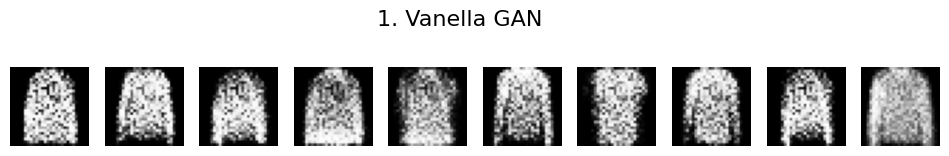

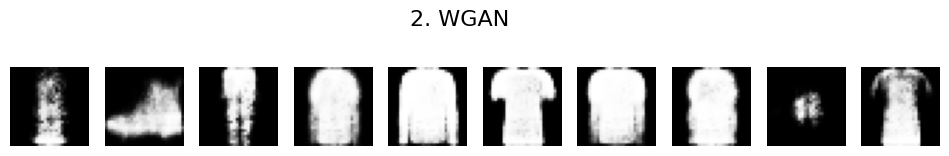

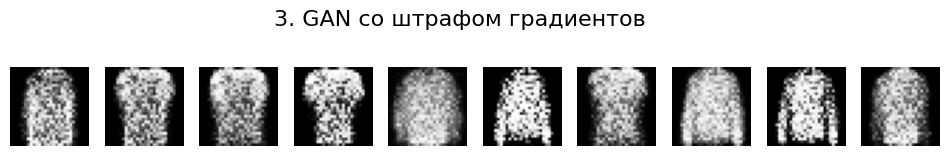

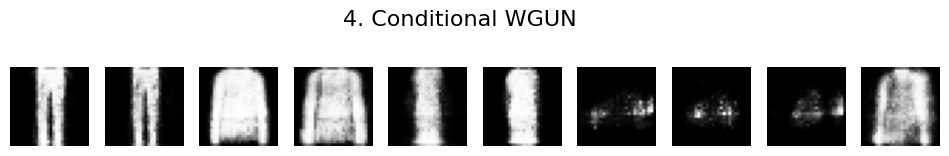

In [200]:
# Добавьте в этот файл анализ полученных результатов с различными графиками обучения
# и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов
# и попробуйте пронаблюдать какие недостатки имеет модель GAN.

noise.data.normal_(0, 1)
fake = generator_vanella(noise)

fig = plt.figure(figsize=(12, 2))
fig.suptitle('1. Vanella GAN', fontsize=16)
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')


noise.data.normal_(0, 1)
fake = generator_wasserstein(noise)

fig = plt.figure(figsize=(12, 2))
fig.suptitle('2. WGAN', fontsize=16)
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')    


noise.data.normal_(0, 1)
fake = generator_grad_pen(noise)

fig = plt.figure(figsize=(12, 2))
fig.suptitle('3. GAN со штрафом градиентов', fontsize=16)
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')      


noise.data.normal_(0, 1)
labels = torch.IntTensor([1,1, 2,2, 3,3, 4,4, 5,5, 6,6, 7,7, 8,8])
fake = conditional_generator(noise, labels)

fig = plt.figure(figsize=(12, 2))
fig.suptitle('4. Conditional WGUN', fontsize=16)
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
    
